In [1]:
from google.colab import drive
drive.mount('/content/drive/')

### imports

In [ ]:
import numpy as np
import csv, json
import pandas as pd
from matplotlib import pyplot as plt
from zipfile import ZipFile
from os.path import expanduser, exists
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.data_utils import get_file

WORKING_DIR = 'drive/My Drive/Colab Notebooks/'

### load and explore data

In [ ]:
data = pd.read_csv(WORKING_DIR + 'finaldata.csv')
data.head()

,question1,question2,is_duplicate,tokenSortRatio,tokenSetRatio,wratio,verb_diff,adj_diff,nn_diff,ne_diff
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,93,100,95,0.000000,0.000000,0.090909,1.0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,63,86,86,1.000000,1.000000,0.230769,1.0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,63,63,60,0.500000,0.333333,0.666667,1.0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,24,28,27,0.666667,1.000000,1.000000,1.0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,47,67,86,1.000000,0.333333,0.600000,0.0


In [ ]:
q1 = data.question1.values
q2 = data.question2.values
labels = data.is_duplicate.values

In [ ]:
questions = q1 + q2
tokenizer = Tokenizer(num_words=200000)
tokenizer.fit_on_texts(questions)
q1_seq = tokenizer.texts_to_sequences(q1)
q2_seq = tokenizer.texts_to_sequences(q2)
word_index = tokenizer.word_index

In [ ]:
len(word_index)

96493

(array([2.90456e+05, 1.03271e+05, 9.62900e+03, 7.23000e+02, 1.81000e+02,
        2.50000e+01, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,  12.7,  25.4,  38.1,  50.8,  63.5,  76.2,  88.9, 101.6,
        114.3, 127. ]),
 <a list of 10 Patch objects>)

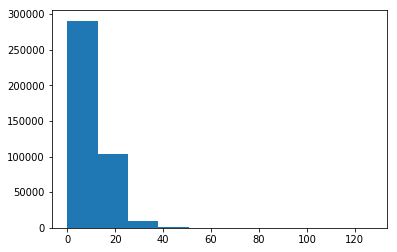

In [ ]:
qlen = [len(q) for q in q1_seq]
plt.hist(qlen)

### use GloVe word embeddings

In [ ]:
GLOVE_ZIP_FILE_URL = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
GLOVE_ZIP_FILE = 'glove.840B.300d.zip'
GLOVE_FILE = 'glove.840B.300d.txt'

In [ ]:
zipfile = ZipFile(get_file(GLOVE_ZIP_FILE, GLOVE_ZIP_FILE_URL))

2176770048/2176768927 [==============================] - 186s 0us/step


In [ ]:
zipfile.extract(GLOVE_FILE, path=WORKING_DIR)

'drive/My Drive/Colab Notebooks/glove.840B.300d.txt'

In [ ]:
embeddings_index = {}
with open(WORKING_DIR + 'glove.840B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

In [ ]:
len(embeddings_index)

2196016

In [ ]:
word_embedding_matrix = np.zeros((len(word_index)+1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector

In [ ]:
q1_data = pad_sequences(q1_seq, maxlen=25)
q2_data = pad_sequences(q2_seq, maxlen=25)
labels = np.array(labels, dtype=int)
print('Shape of question1 data tensor:', q1_data.shape)
print('Shape of question2 data tensor:', q2_data.shape)
print('Shape of label tensor:', labels.shape)

Shape of question1 data tensor: (404287, 25)
Shape of question2 data tensor: (404287, 25)
Shape of label tensor: (404287,)


In [ ]:
q1_data[10]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,   961,     7,
          87,  4685,    10, 31252,   146, 31253, 55752], dtype=int32)

### import keras

In [ ]:
import numpy as np
import pandas as pd
import datetime, time, json
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, concatenate, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split


### prepare train and test data

In [ ]:
X = np.stack((q1_data, q2_data), axis=1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

In [ ]:
Q1_train.shape

(283000, 25)

### build lstm network

In [ ]:
MODEL_WEIGHTS_FILE = 'question_pairs_weights.h5'
MAX_SEQUENCE_LENGTH = 25
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.1
TEST_SPLIT = 0.3
RNG_SEED = 13371447
NB_EPOCHS = 25
DROPOUT = 0.1
BATCH_SIZE = 32
nb_words = len(word_index)

In [ ]:
question1 = Input(shape=(MAX_SEQUENCE_LENGTH,))
question2 = Input(shape=(MAX_SEQUENCE_LENGTH,))

q1 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question1)
q1 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q1)
q1 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q1)

q2 = Embedding(nb_words + 1, 
                 EMBEDDING_DIM, 
                 weights=[word_embedding_matrix], 
                 input_length=MAX_SEQUENCE_LENGTH, 
                 trainable=False)(question2)
q2 = TimeDistributed(Dense(EMBEDDING_DIM, activation='relu'))(q2)
q2 = Lambda(lambda x: K.max(x, axis=1), output_shape=(EMBEDDING_DIM, ))(q2)

net = concatenate([q1,q2])
net = Dense(200, activation='relu')(net)
net = Dropout(DROPOUT)(net)
net = BatchNormalization()(net)
net = Dense(200, activation='relu')(net)
net = Dropout(DROPOUT)(net)
net = BatchNormalization()(net)
net = Dense(200, activation='relu')(net)
net = Dropout(DROPOUT)(net)
net = BatchNormalization()(net)

label = Dense(1, activation='sigmoid')(net)

model = Model(inputs=[question1,question2], outputs=label)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### train and test lstm network

In [ ]:
print("Starting training at", datetime.datetime.now())
t0 = time.time()
callbacks = [ModelCheckpoint(MODEL_WEIGHTS_FILE, monitor='val_acc', save_best_only=True)]
history = model.fit([Q1_train, Q2_train],
                    y_train,
                    epochs=NB_EPOCHS,
                    validation_split=VALIDATION_SPLIT,
                    verbose=2,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks)
t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

In [ ]:
model.load_weights(MODEL_WEIGHTS_FILE)
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
print('loss = {0:.4f}, accuracy = {1:.4f}'.format(loss, accuracy))

loss = 0.4345, accuracy = 0.8041


In [ ]:
y_pred = model.predict([Q1_test, Q2_test])
y_classes = y_pred.argmax(axis=-1)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

y_pred =(y_pred>0.5)
list(y_pred)

cm = confusion_matrix(y_test, y_pred)

In [ ]:
cm

array([[65464, 11044],
       [12718, 32061]])

### calculate performance metrics

In [ ]:
accuracy_score(y_test, y_pred)

0.8040845267835794

In [ ]:
precision_score(y_test, y_pred)

0.7437884236167498

In [ ]:
recall_score(y_test, y_pred)

0.715982938430961

### plot confusion matrices

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

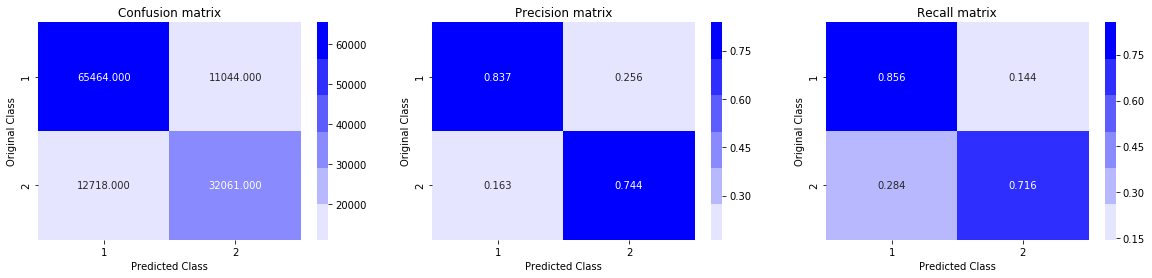

In [ ]:
plot_confusion_matrix(y_test, y_pred)